In [1]:
from sys import call_tracing
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import OPTICS, DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
import umap
import mpl_toolkits.mplot3d.axes3d as p3
import os

In [2]:
win_size = 10
use_log = True
use_std = True
# ignore the first day
ignored = 1440

# group_func = 'mean'
group_func = 'mean_and_median'

# umap n_neighbors argument
nn = 50

reducers = {
    'pca': PCA(n_components=3),
    # 'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=5, random_state=5566),
    'umap': umap.UMAP(n_components=3, metric='cosine', n_neighbors=nn, random_state=5566),
    # 'umap': umap.UMAP(n_components=3, n_neighbors=15, random_state=5566),
}

In [3]:
conv_size = 3
txts = [f for f in os.listdir('./aligned') if f.endswith('.txt')]
monitor_cleaned_smooths = []
act_digests = []
act_origs = []
metas = []

meta2 = pd.read_csv('./meta/meta2.csv', sep='\t')
#one_meta2_test = pd.read_csv('./meta/one_meta2_test.csv', sep='\t')
for txt in txts:

    # try:
    #     meta = pd.read_csv('./meta/%s' % txt, sep='\t')
    # except:
    #     continue

    #meta = one_meta2_test[one_meta2_test.File_Name == os.path.splitext(txt)[0]]
    meta = meta2[meta2.File_Name == os.path.splitext(txt)[0]]
    if len(meta) == 0:
        print(txt)
        continue

    monitor = pd.read_csv('./aligned/%s' % txt, sep='\t', header=None)
    monitor = monitor.rename({1:'date', 2:'time'}, axis=1)
    monitor_cleaned = pd.concat([monitor.iloc[:,1:3], monitor.iloc[:,10:]], axis=1)
    monitor_cleaned = monitor_cleaned.iloc[ignored:,:]
    
    #### light dark filter implementation
    #hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned.time], dtype=int)
    #monitor_cleaned['h'] = hms[:,0]
    
    # light
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h >= 5) & (monitor_cleaned.h <= 19)].iloc[:,:-1]
    
    # dark 
    #monitor_cleaned = monitor_cleaned[(monitor_cleaned.h <= 5) | (monitor_cleaned.h >= 19)].iloc[:,:-1]
    ####
    
    # monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.array([1,1,1,1,1]), mode='valid')
    monitor_cleaned_smooth = monitor_cleaned.iloc[:,2:].apply(np.convolve, v=np.ones(conv_size), mode='valid')
    
    if use_log:
        monitor_cleaned_smooth = np.log(monitor_cleaned_smooth + 1)

    monitor_cleaned_smooth = pd.concat([monitor_cleaned.iloc[(conv_size-1):,:2].reset_index(drop=True), monitor_cleaned_smooth], axis=1)

    hms = np.array([t.replace(' ', ':').split(':') for t in monitor_cleaned_smooth.time], dtype=int)
    monitor_cleaned_smooth['h'] = hms[:,0]
    monitor_cleaned_smooth['mNcell'] = hms[:,1] // win_size
    #monitor_cleaned_smooth = monitor_cleaned_smooth[monitor_cleaned_smooth.h.isin([18,19,20,21,22,23,0,1,2,3,4,5])]
    #monitor_cleaned_smooth['m'] = hms[:,1]
    
    if group_func == 'mean':
        act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
    else:
        # act_digest = pd.concat([monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T], axis=1)
        q1 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.25).T.iloc[:-2]
        q3 = monitor_cleaned_smooth.groupby(['h', 'mNcell']).apply(pd.DataFrame.quantile, q=.75).T.iloc[:-2]

        monitor_cleaned_smooth_min = monitor_cleaned_smooth.groupby(['h', 'mNcell']).min().T.iloc[2:]
        monitor_cleaned_smooth_max = monitor_cleaned_smooth.groupby(['h', 'mNcell']).max().T.iloc[2:]
        IQR = q3 - q1
        monitor_cleaned_smooth_whisker_min = q1 - 1.5 * IQR
        monitor_cleaned_smooth_whisker_max = q3 + 1.5 * IQR
        
        whisker_min_oob = (monitor_cleaned_smooth_whisker_min < monitor_cleaned_smooth_min)
        whisker_max_oob = (monitor_cleaned_smooth_whisker_max > monitor_cleaned_smooth_max)
        monitor_cleaned_smooth_whisker_min[whisker_min_oob] = monitor_cleaned_smooth_min[whisker_min_oob]
        monitor_cleaned_smooth_whisker_max[whisker_max_oob] = monitor_cleaned_smooth_max[whisker_max_oob]
        
        act_digest = pd.concat([
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T, 
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T,
            monitor_cleaned_smooth.groupby(['h', 'mNcell']).median().T, 
            q1,
            q3,
            monitor_cleaned_smooth_whisker_min,
            monitor_cleaned_smooth_whisker_max,
            ], axis=1)
    
    act_orig = monitor_cleaned_smooth.iloc[:,2:34].T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T / monitor_cleaned_smooth.groupby(['h', 'mNcell']).std().T
    #act_digest = monitor_cleaned_smooth.groupby(['h', 'mNcell']).mean().T
    act_digests.append(act_digest)
    act_origs.append(act_orig)

    metas.append(meta)
    monitor_cleaned_smooths.append(monitor_cleaned_smooth)

meta_union = pd.concat(metas).reset_index(drop=True)
np.sum(meta_union.Instar.isna())
act_digests_npy = np.concatenate(act_digests)
act_origs_npy = np.concatenate(act_origs)
monitor_cleaned_smooths_union = pd.concat(monitor_cleaned_smooths).reset_index(drop=True)

In [4]:
# filter out BF
filter_no_bf = (meta_union['Source'] == 'MF') | (meta_union['Source'] == 'WL') | (meta_union['Source'] == 'OK') | (meta_union['Source'] == 'SC')
meta_filter = meta_union[filter_no_bf]
act_filter = act_digests_npy[filter_no_bf]
#act_filter.shape

In [131]:
np.unique(meta_filter.phen_idx, return_inverse=True)

array([0., 1.])

In [5]:
def stdscaler (X, use_std=True):
    if use_std:
        return StandardScaler().fit_transform(X)
    else:
        return X

In [6]:
reducer = umap.UMAP(n_components=3, metric='cosine', n_neighbors=15, random_state=5566)
#reducer = PCA(n_components=3, random_state=5566)

act_filter_transformed = stdscaler(act_filter, use_std)
dr = reducer.fit_transform(act_filter_transformed)
act_filter_transformed.shape
dr.shape
# reducer.fit(act_digests_npy_transformed)
# reducer.transform(act_digests_npy_transformed)
pwdists = pairwise_distances(dr)

pwdists.shape

(296, 296)

### Logistic Regression

In [7]:
# Importing packages

import pandas as pd # data processing
import numpy as np # working with arrays
import itertools # construct specialized tools
import matplotlib.pyplot as plt # visualizations
from matplotlib import rcParams # plot size customization
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.linear_model import LogisticRegression # model algorithm
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.metrics import jaccard_score as jss # evaluation metric
from sklearn.metrics import precision_score # evaluation metric
from sklearn.metrics import classification_report # evaluation metric
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import log_loss # evaluation metric

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [94]:
act_filter_transformed.shape

(296, 1008)

In [9]:
rfc = RandomForestClassifier(random_state=5566, max_depth=5, n_estimators=200, criterion='gini')

In [12]:
X = np.asarray(act_filter_transformed)
y = np.asarray(meta_filter['phen_idx'])

In [13]:
meta_filter['phen_idx'].value_counts()

0.0    272
1.0     24
Name: phen_idx, dtype: int64

In [16]:
X = StandardScaler().fit(X).transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 5566)

In [18]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, random_state=5566)

In [19]:
rfc.score(X_test, y_test)

0.918918918918919

In [20]:
np.argsort(rfc.feature_importances_)

array([503, 621, 622, ..., 402, 116, 978])

In [21]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.9121621621621622

### ==================================================================
### from sklearn doc
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [8]:
X = np.asarray(act_filter_transformed)
y = np.asarray(meta_filter['phen_idx'])

In [14]:
#X.shape
y.shape

(296,)

(296,)

In [ ]:
clf = LogisticRegression(random_state=5566).fit(X, y)
clf.predict(X)
clf.predict_proba(X)
clf.score(X, y)

https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html

In [50]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [52]:
class_names = iris.target_names
class_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [55]:
class_names = np.asarray(meta_filter['phen_idx'])
class_names

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
names = []
for i in meta_filter['phen_idx']:
    #print(i)
    if i == 1:
        names.append('year-round')
    else:
        names.append('seasonal')
    
class_names = np.asarray(names)
class_names

Confusion matrix, without normalization
[[63  1]
 [ 9  1]]
Normalized confusion matrix
[[0.98 0.02]
 [0.9  0.1 ]]


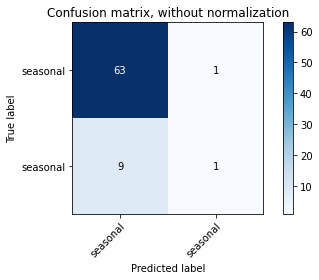

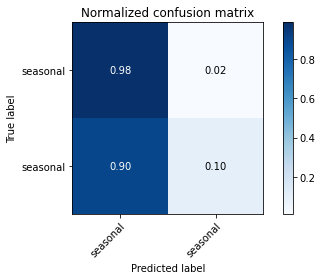

In [127]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
X = np.asarray(act_filter_transformed)
y = np.asarray(meta_filter['phen_idx'])

names = []
for i in meta_filter['phen_idx']:
    #print(i)
    if i == 1:
        names.append('year-round')
    else:
        names.append('seasonal')

class_names = np.asarray(names)



# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5566)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred).astype(int)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [126]:
classes[unique_labels(y_test, y_pred).astype(int)]

NameError: name 'classes' is not defined

### ==================================================================
### from CodeX example
https://medium.com/codex/machine-learning-logistic-regression-with-python-5ed4ded9d146

In [22]:

from sklearn.linear_model import LogisticRegression
X = np.asarray(act_filter_transformed)
y = np.asarray(meta_filter['phen_idx'])
#X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)
clf.predict(X)

clf.predict_proba(X)

clf.score(X, y)


0.9966216216216216

In [23]:
X_var = np.asarray(act_filter_transformed)
y_var = np.asarray(meta_filter['phen_idx'])

In [24]:
meta_filter['phen_idx'].value_counts()

0.0    272
1.0     24
Name: phen_idx, dtype: int64

In [25]:
X_var = StandardScaler().fit(X_var).transform(X_var)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = 0.5, random_state = 5566)

In [27]:
# Modelling

lr = LogisticRegression(C = 0.1, solver = 'liblinear')
lr.fit(X_train,y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [28]:
yhat.mean()

NameError: name 'yhat' is not defined

In [29]:
# Predictions

yhat = lr.predict(X_test)
yhat_prob = lr.predict_proba(X_test)
# Predictions

In [85]:
lr.coef_

array([[ 0.01,  0.05, -0.02, ...,  0.02, -0.07, -0.03]])

In [81]:
lr.classes_

array([0., 1.])

In [82]:
print('yhat samples : ', yhat[:10])
print('yhat_prob samples : ', yhat_prob[:10])

yhat samples :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
yhat_prob samples :  [[0.95 0.05]
 [0.9  0.1 ]
 [0.97 0.03]
 [0.93 0.07]
 [0.96 0.04]
 [0.9  0.1 ]
 [0.93 0.07]
 [0.87 0.13]
 [0.82 0.18]
 [0.87 0.13]]


In [30]:
# 1. Jaccard Index
# We can define Jaccard as the size of the intersection divided by the size of the union of two label sets. 
# If the entire set of predicted labels for a sample strictly match the true set of labels, 
# then the subset accuracy is 1.0; otherwise, it is 0.0

print('Jaccard Similarity Score of our model is {}'.format(jss(y_test, yhat).round(2)))

Jaccard Similarity Score of our model is 0.1


In [31]:
# 2. Precision Score

print('Precision Score of our model is {}'.format(precision_score(y_test, yhat).round(2)))

Precision Score of our model is 0.12


In [32]:
# 3. Log loss
# In logistic regression, the output can be the probability of customer churn is yes (or equals to 1). 
# This probability is a value between 0 and 1. Log loss( Logarithmic loss) measures the performance of 
# a classifier where the predicted output is a probability value between 0 and 1. 
# Remember that, lower the log loss value higher the accuracy of our model.

print('Log Loss of our model is {}'.format(log_loss(y_test, yhat).round(2)))

Log Loss of our model is 10.04


In [33]:
# 4. Classificaton report

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.93      0.74      0.82       136
         1.0       0.12      0.42      0.19        12

    accuracy                           0.71       148
   macro avg       0.53      0.58      0.51       148
weighted avg       0.87      0.71      0.77       148



Based on the count of each section, we can calculate the precision and recall of each label:
<br/> **Precision** is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)
<br/> **Recall** is true positive rate. It is defined as: Recall = TP / (TP + FN)
<br/>So, we can calculate the precision and recall of each class.
<br/> **F1 score**: Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label. The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifier has a good value for both recall and precision.
<br/>And finally, we can tell the average accuracy for this classifier is the average of the F1-score for both labels, which is 0.74 in our case.

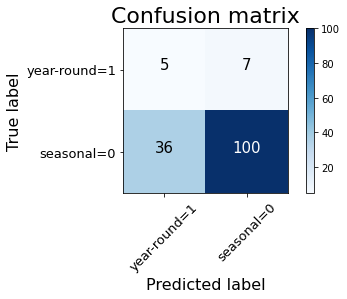

In [34]:
# 5. Confusion matrix

def plot_confusion_matrix(cm, classes,normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    
    # Interpolation: Interpolation is the process of using the line of best fit to estimate the value of 
    # one variable from the value of another, provided that the value you are using is within the range of your data.
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, fontsize = 13)
    plt.yticks(tick_marks, classes, fontsize = 13)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 fontsize = 15,
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 16)
    plt.xlabel('Predicted label', fontsize = 16)

# Compute confusion matrix

cnf_matrix = confusion_matrix(y_test, yhat, labels = [1,0])
np.set_printoptions(precision = 2)


# Plot non-normalized confusion matrix

plt.figure()
plot_confusion_matrix(cnf_matrix, classes = ['year-round=1','seasonal=0'], normalize = False,  title = 'Confusion matrix')
plt.savefig('confusion_matrix.png')

### ====================================================================
https://scikit-learn.org/0.20/auto_examples/model_selection/plot_confusion_matrix.html

Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.62 0.38]
 [0.   0.   1.  ]]


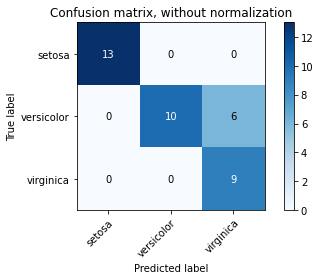

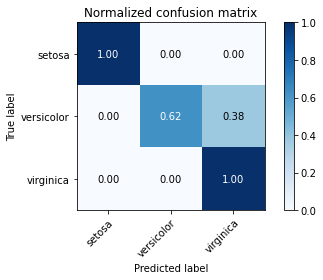

In [118]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [120]:
class_names = iris.target_names
print(class_names)

['setosa' 'versicolor' 'virginica']
